<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in New York City</font></h1>

## Introduction

In this lab, you will learn how to convert addresses into their equivalent latitude and longitude values. Also, you will use the Foursquare API to explore neighborhoods in New York City. You will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. You will use the *k*-means clustering algorithm to complete this task. Finally, you will use the Folium library to visualize the neighborhoods in New York City and their emerging clusters.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt
import seaborn as sns

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.

In [2]:
#!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [3]:
#filepath = "./Desktop/newyork_data.json"
filepath = "./Documents/DataScience/newyork_data.json"

with open(filepath) as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [4]:
# newyork_data

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [5]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [6]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [8]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [10]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [12]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [13]:
# create map of New York using latitude and longitude values
f = folium.Figure(width=800, height=400)
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11).add_to(f)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [14]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.

In [15]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


As we did with all of New York City, let's visualizat Manhattan the neighborhoods in it.

In [16]:
# create map of Manhattan using latitude and longitude values
f = folium.Figure(width=800, height=400)
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11).add_to(f)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [17]:
CLIENT_ID = 'F1AJUU1UFHUIEB202G545SYM1XW0VMFJWBJODFLWLT2KILTG' # your Foursquare ID
CLIENT_SECRET = '1HFZHUCGQMPT21FECK2I2VCOC4ZPJO5WO50LEII1PTKGVFCJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: F1AJUU1UFHUIEB202G545SYM1XW0VMFJWBJODFLWLT2KILTG
CLIENT_SECRET:1HFZHUCGQMPT21FECK2I2VCOC4ZPJO5WO50LEII1PTKGVFCJ


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [18]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Get the neighborhood's latitude and longitude values.

In [19]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [20]:
# type your answer here
LIMIT = 100
radius = 500


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            neighborhood_latitude, 
            neighborhood_longitude, 
            radius, 
            LIMIT)




Double-click __here__ for the solution.
<!-- The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
-->

<!--
radius = 500 # define radius
-->

<!--
\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
--> 

Send the GET request and examine the resutls

In [21]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e8908e0923935001b50c6e3'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Marble Hill',
  'headerFullLocation': 'Marble Hill, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 25,
  'suggestedBounds': {'ne': {'lat': 40.88105078329964,
    'lng': -73.90471933917806},
   'sw': {'lat': 40.87205077429964, 'lng': -73.91659997808156}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4429abf964a52037f225e3',
       'name': "Arturo's",
       'location': {'address': '5198 Broadway',
        'crossStreet': 'at 225th St.',
        'lat': 40.87441177110231,
        'lng': -73.91027100981574,
        'labeledLatLngs': [{'label'

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [23]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271
1,Bikram Yoga,Yoga Studio,40.876844,-73.906204
2,Tibbett Diner,Diner,40.880404,-73.908937
3,Dunkin',Donut Shop,40.877136,-73.906666
4,Starbucks,Coffee Shop,40.877531,-73.905582


And how many venues were returned by Foursquare?

In [24]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

25 venues were returned by Foursquare.


<a id='item2'></a>

## 2. Explore Neighborhoods in Manhattan

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [26]:
# type your answer here

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )



Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Double-click __here__ for the solution.
<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 

#### Let's check the size of the resulting dataframe

In [27]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3279, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


Let's check how many venues were returned for each neighborhood

In [28]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,87,87,87,87,87,87
Carnegie Hill,93,93,93,93,93,93
Central Harlem,42,42,42,42,42,42
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,39,39,39,39,39,39
East Village,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [29]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 330 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [30]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pop-Up Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shoppin

And let's examine the new dataframe size.

In [31]:
manhattan_onehot.shape

(3279, 331)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [32]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pop-Up Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shoppin

#### Let's confirm the new size

In [33]:
manhattan_grouped.shape

(40, 331)

#### Let's print each neighborhood along with the top 5 most common venues

In [34]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.07
1          Hotel  0.06
2    Coffee Shop  0.06
3  Shopping Mall  0.03
4  Boat or Ferry  0.03


----Carnegie Hill----
            venue  freq
0     Coffee Shop  0.06
1            Café  0.05
2     Pizza Place  0.04
3          Bakery  0.03
4  Cosmetics Shop  0.03


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1    French Restaurant  0.05
2   Chinese Restaurant  0.05
3  American Restaurant  0.05
4                  Bar  0.05


----Chelsea----
                 venue  freq
0          Coffee Shop  0.07
1               Bakery  0.05
2   Italian Restaurant  0.04
3  American Restaurant  0.03
4       Ice Cream Shop  0.03


----Chinatown----
                 venue  freq
0   Chinese Restaurant  0.08
1         Cocktail Bar  0.05
2  American Restaurant  0.04
3   Salon / Barbershop  0.03
4    Hotpot Restaurant  0.03


----Civic Center----
                  venue  freq
0           Coffee Shop  0.06


#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Coffee Shop,Wine Shop,Boat or Ferry,Memorial Site,Shopping Mall,Clothing Store,Gym,Food Court
1,Carnegie Hill,Coffee Shop,Café,Pizza Place,Cosmetics Shop,French Restaurant,Bookstore,Wine Shop,Bakery,Gym / Fitness Center,Gym
2,Central Harlem,African Restaurant,Chinese Restaurant,Bar,American Restaurant,French Restaurant,Seafood Restaurant,Caribbean Restaurant,Library,Bookstore,Boutique
3,Chelsea,Coffee Shop,Bakery,Italian Restaurant,Hotel,Ice Cream Shop,American Restaurant,French Restaurant,Theater,Bookstore,Market
4,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Salon / Barbershop,Optical Shop,Dessert Shop,Vietnamese Restaurant,Spa,Hotpot Restaurant,Bakery


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [37]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)
# manhattan_grouped_clustering
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 0, 1, 1, 1, 3, 0, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,4,Sandwich Place,Gym,American Restaurant,Coffee Shop,Yoga Studio,Pharmacy,Steakhouse,Shopping Mall,Seafood Restaurant,Pizza Place
1,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Cocktail Bar,American Restaurant,Salon / Barbershop,Optical Shop,Dessert Shop,Vietnamese Restaurant,Spa,Hotpot Restaurant,Bakery
2,Manhattan,Washington Heights,40.851903,-73.936900,3,Café,Grocery Store,Bakery,Chinese Restaurant,Mobile Phone Shop,Deli / Bodega,Mexican Restaurant,Latin American Restaurant,Supermarket,Supplement Shop
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Café,Lounge,Pizza Place,Restaurant,American Restaurant,Chinese Restaurant,Frozen Yogurt Shop,Bakery,Park
4,Manhattan,Hamilton Heights,40.823604,-73.949688,3,Pizza Place,Café,Coffee Shop,Deli / Bodega,Mexican Restaurant,Sushi Restaurant,Caribbean Restaurant,School,Bakery,Sandwich Place


Finally, let's visualize the resulting clusters

In [39]:
# create map
f = folium.Figure(width=800, height=400)
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11).add_to(f)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [40]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Manhattanville,Coffee Shop,Seafood Restaurant,Mexican Restaurant,Italian Restaurant,Park,Spanish Restaurant,Climbing Gym,Bike Trail,Liquor Store,Lounge
9,Yorkville,Italian Restaurant,Coffee Shop,Gym,Bar,Pizza Place,Deli / Bodega,Sushi Restaurant,Japanese Restaurant,Mexican Restaurant,Wine Shop
10,Lenox Hill,Italian Restaurant,Coffee Shop,Sushi Restaurant,Pizza Place,Cocktail Bar,Gym / Fitness Center,Café,Gym,Burger Joint,Salad Place
12,Upper West Side,Italian Restaurant,Bar,Wine Bar,Mediterranean Restaurant,Indian Restaurant,Coffee Shop,Bakery,Café,Sushi Restaurant,Yoga Studio
13,Lincoln Square,Italian Restaurant,Plaza,Café,Theater,Performing Arts Venue,American Restaurant,Concert Hall,Gym / Fitness Center,Indie Movie Theater,Gym
17,Chelsea,Coffee Shop,Bakery,Italian Restaurant,Hotel,Ice Cream Shop,American Restaurant,French Restaurant,Theater,Bookstore,Market
18,Greenwich Village,Italian Restaurant,Clothing Store,Sushi Restaurant,Café,French Restaurant,Indian Restaurant,American Restaurant,Gym,Bubble Tea Shop,Cosmetics Shop
19,East Village,Bar,Pizza Place,Ice Cream Shop,Wine Bar,Mexican Restaurant,Cocktail Bar,Coffee Shop,Korean Restaurant,Ramen Restaurant,Vegetarian / Vegan Restaurant
21,Tribeca,American Restaurant,Park,Italian Restaurant,Spa,Café,Greek Restaurant,Wine Bar,Men's Store,Coffee Shop,Hotel
22,Little Italy,Bakery,Café,Bubble Tea Shop,Italian Restaurant,Mediterranean Restaurant,Salon / Barbershop,Sandwich Place,Cocktail Bar,Hotel,Tea Room


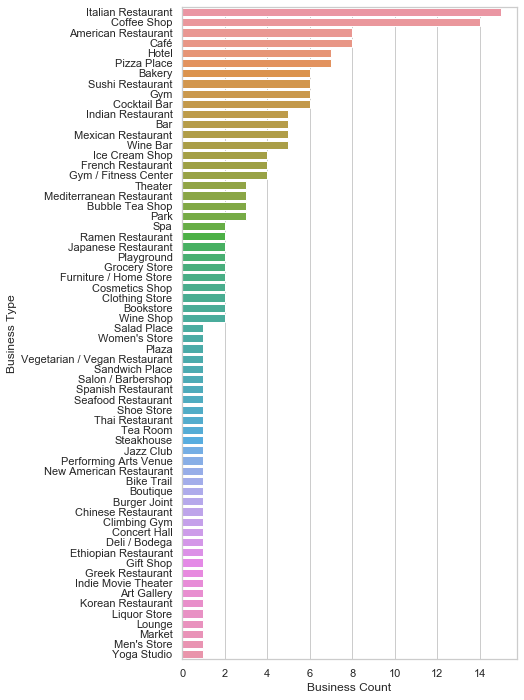

In [42]:
Cluster_1 = pd.DataFrame(manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]])
columnNames = ['Business Type']

Cluster_1_count = pd.DataFrame(columns = columnNames)
Cluster_1_count['Business Type'] = pd.concat([Cluster_1['1st Most Common Venue'], Cluster_1['2nd Most Common Venue'], Cluster_1['3rd Most Common Venue'],
                                             Cluster_1['4th Most Common Venue'], Cluster_1['5th Most Common Venue'], Cluster_1['6th Most Common Venue'], 
                                             Cluster_1['7th Most Common Venue'], Cluster_1['8th Most Common Venue'], Cluster_1['9th Most Common Venue'], 
                                              Cluster_1['10th Most Common Venue']], axis =0, ignore_index =True)

Cluster_1_count['Business Count'] = 1
Cluster_1_count.shape


Cluster_1_count = Cluster_1_count.groupby(['Business Type'])['Business Count'].sum().reset_index()
Cluster_1_count = Cluster_1_count.sort_values(by=['Business Count'], ascending=False)

sns.set(style="whitegrid")
plt.subplots(figsize=(6, 12))
ax = sns.barplot(y = "Business Type", x = "Business Count", data=Cluster_1_count)


In [43]:
fig = ax.get_figure()

fig.savefig("NY_Explore_Cluster_1.png", bbox_inches = 'tight')

In [62]:
NY_Explore_Cluster_1 = set(Cluster_1['Neighborhood'])
print("Neighborhoods in Cluster 1 are: ", NY_Explore_Cluster_1)

Neighborhoods in Cluster 1 are:  {'Lincoln Square', 'Little Italy', 'Manhattan Valley', 'Upper West Side', 'Sutton Place', 'Tribeca', 'Greenwich Village', 'Lenox Hill', 'Manhattanville', 'East Village', 'Chelsea', 'Soho', 'Carnegie Hill', 'Noho', 'West Village', 'Gramercy', 'Turtle Bay', 'Yorkville'}


#### Cluster 2

In [44]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Salon / Barbershop,Optical Shop,Dessert Shop,Vietnamese Restaurant,Spa,Hotpot Restaurant,Bakery
6,Central Harlem,African Restaurant,Chinese Restaurant,Bar,American Restaurant,French Restaurant,Seafood Restaurant,Caribbean Restaurant,Library,Bookstore,Boutique
8,Upper East Side,Italian Restaurant,Coffee Shop,Bakery,Art Gallery,Gym / Fitness Center,Juice Bar,Exhibit,Yoga Studio,Hotel,French Restaurant
11,Roosevelt Island,Coffee Shop,Bubble Tea Shop,Sandwich Place,Greek Restaurant,Outdoors & Recreation,Farmers Market,Dog Run,Liquor Store,Scenic Lookout,Gym / Fitness Center
14,Clinton,Theater,Gym / Fitness Center,Italian Restaurant,Coffee Shop,Spa,American Restaurant,Hotel,Wine Shop,Gym,Sandwich Place
15,Midtown,Hotel,Clothing Store,Coffee Shop,Sporting Goods Shop,Bookstore,French Restaurant,Theater,Café,Steakhouse,Bakery
16,Murray Hill,Coffee Shop,Sandwich Place,Japanese Restaurant,Hotel,American Restaurant,Gym / Fitness Center,Bar,Italian Restaurant,Mediterranean Restaurant,Cocktail Bar
20,Lower East Side,Chinese Restaurant,Café,Coffee Shop,Theater,Japanese Restaurant,Cocktail Bar,Bakery,Art Gallery,Ramen Restaurant,Sandwich Place
28,Battery Park City,Park,Hotel,Coffee Shop,Wine Shop,Boat or Ferry,Memorial Site,Shopping Mall,Clothing Store,Gym,Food Court
29,Financial District,Coffee Shop,Bar,American Restaurant,Gym,Pizza Place,Food Truck,Gym / Fitness Center,Japanese Restaurant,Cocktail Bar,Italian Restaurant


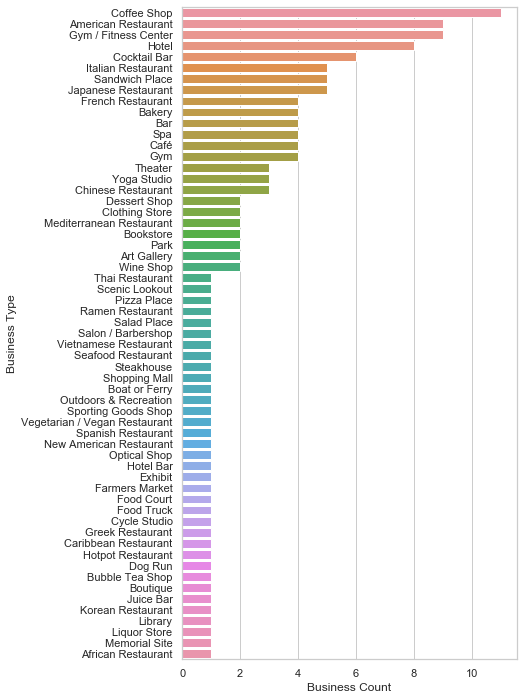

In [45]:
Cluster_2 = pd.DataFrame(manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]])
columnNames = ['Business Type']

Cluster_2_count = pd.DataFrame(columns = columnNames)
Cluster_2_count['Business Type'] = pd.concat([Cluster_2['1st Most Common Venue'], Cluster_2['2nd Most Common Venue'], Cluster_2['3rd Most Common Venue'],
                                             Cluster_2['4th Most Common Venue'], Cluster_2['5th Most Common Venue'], Cluster_2['6th Most Common Venue'], 
                                             Cluster_2['7th Most Common Venue'], Cluster_2['8th Most Common Venue'], Cluster_2['9th Most Common Venue'], 
                                              Cluster_2['10th Most Common Venue']], axis =0, ignore_index =True)

Cluster_2_count['Business Count'] = 1
Cluster_2_count.shape


Cluster_2_count = Cluster_2_count.groupby(['Business Type'])['Business Count'].sum().reset_index()
Cluster_2_count = Cluster_2_count.sort_values(by=['Business Count'], ascending=False)

sns.set(style="whitegrid")
plt.subplots(figsize=(6, 12))
ax = sns.barplot(y = "Business Type", x = "Business Count", data=Cluster_2_count)


In [46]:
fig = ax.get_figure()

fig.savefig("NY_Explore_Cluster_2.png", bbox_inches = 'tight')

In [47]:
NY_Explore_Cluster_2 = set(Cluster_2['Neighborhood'])
print("Neighborhoods in Cluster 2 are: ", NY_Explore_Cluster_2)

Neighborhoods in Cluster 2 are:  {'Financial District', 'Roosevelt Island', 'Clinton', 'Flatiron', 'Hudson Yards', 'Lower East Side', 'Battery Park City', 'Upper East Side', 'Chinatown', 'Murray Hill', 'Civic Center', 'Midtown South', 'Central Harlem', 'Midtown'}


#### Cluster 3

In [48]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Boat or Ferry,Bar,Park,Heliport,Gym / Fitness Center,Gas Station,Harbor / Marina,Pet Service,Farmers Market,Coffee Shop


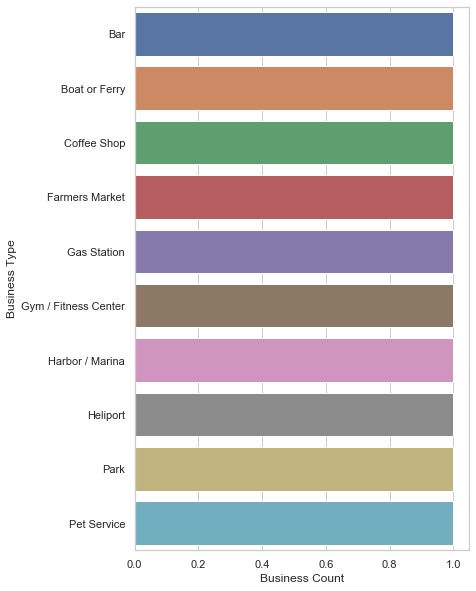

In [49]:
Cluster_3 = pd.DataFrame(manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]])
columnNames = ['Business Type']

Cluster_3_count = pd.DataFrame(columns = columnNames)
Cluster_3_count['Business Type'] = pd.concat([Cluster_3['1st Most Common Venue'], Cluster_3['2nd Most Common Venue'], Cluster_3['3rd Most Common Venue'],
                                             Cluster_3['4th Most Common Venue'], Cluster_3['5th Most Common Venue'], Cluster_3['6th Most Common Venue'], 
                                             Cluster_3['7th Most Common Venue'], Cluster_3['8th Most Common Venue'], Cluster_3['9th Most Common Venue'], 
                                              Cluster_3['10th Most Common Venue']], axis =0, ignore_index =True)

Cluster_3_count['Business Count'] = 1
Cluster_3_count.shape


Cluster_3_count = Cluster_3_count.groupby(['Business Type'])['Business Count'].sum().reset_index()
Cluster_3_count = Cluster_3_count.sort_values(by=['Business Count'], ascending=False)

sns.set(style="whitegrid")
plt.subplots(figsize=(6, 10))
ax = sns.barplot(y = "Business Type", x = "Business Count", data=Cluster_3_count)


In [50]:
fig = ax.get_figure()
fig.savefig("NY_Explore_Cluster_3.png", bbox_inches = 'tight')

In [51]:
NY_Explore_Cluster_3 = set(Cluster_3['Neighborhood'])
print("Neighborhoods in Cluster 3 are: ", NY_Explore_Cluster_3)

Neighborhoods in Cluster 3 are:  {'Stuyvesant Town'}


#### Cluster 4

In [52]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,Café,Grocery Store,Bakery,Chinese Restaurant,Mobile Phone Shop,Deli / Bodega,Mexican Restaurant,Latin American Restaurant,Supermarket,Supplement Shop
3,Inwood,Mexican Restaurant,Café,Lounge,Pizza Place,Restaurant,American Restaurant,Chinese Restaurant,Frozen Yogurt Shop,Bakery,Park
4,Hamilton Heights,Pizza Place,Café,Coffee Shop,Deli / Bodega,Mexican Restaurant,Sushi Restaurant,Caribbean Restaurant,School,Bakery,Sandwich Place
7,East Harlem,Mexican Restaurant,Bakery,Thai Restaurant,Latin American Restaurant,Deli / Bodega,Steakhouse,Cocktail Bar,French Restaurant,Beer Bar,Grocery Store
26,Morningside Heights,Park,Coffee Shop,American Restaurant,Bookstore,Sandwich Place,Deli / Bodega,Burger Joint,Seafood Restaurant,Tennis Court,Farmers Market
36,Tudor City,Park,Café,Mexican Restaurant,Deli / Bodega,Greek Restaurant,Pizza Place,Coffee Shop,Spanish Restaurant,Thai Restaurant,Gym


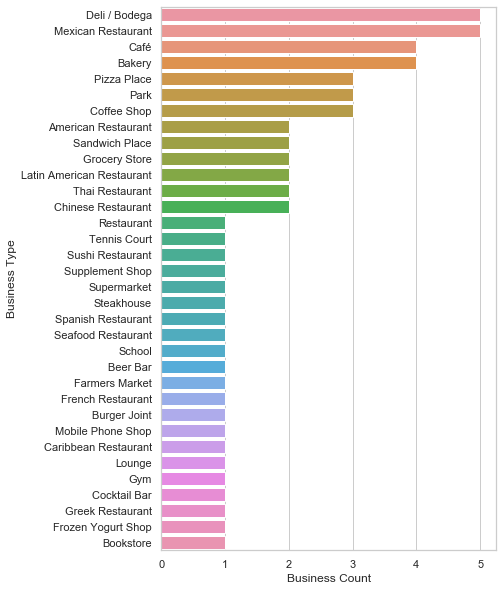

In [54]:
Cluster_4 = pd.DataFrame(manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]])
columnNames = ['Business Type']

Cluster_4_count = pd.DataFrame(columns = columnNames)
Cluster_4_count['Business Type'] = pd.concat([Cluster_4['1st Most Common Venue'], Cluster_4['2nd Most Common Venue'], Cluster_4['3rd Most Common Venue'],
                                             Cluster_4['4th Most Common Venue'], Cluster_4['5th Most Common Venue'], Cluster_4['6th Most Common Venue'], 
                                             Cluster_4['7th Most Common Venue'], Cluster_4['8th Most Common Venue'], Cluster_4['9th Most Common Venue'], 
                                              Cluster_4['10th Most Common Venue']], axis =0, ignore_index =True)

Cluster_4_count['Business Count'] = 1
Cluster_4_count.shape


Cluster_4_count = Cluster_4_count.groupby(['Business Type'])['Business Count'].sum().reset_index()
Cluster_4_count = Cluster_4_count.sort_values(by=['Business Count'], ascending=False)

sns.set(style="whitegrid")
plt.subplots(figsize=(6, 10))
ax = sns.barplot(y = "Business Type", x = "Business Count", data=Cluster_4_count)


In [55]:
fig = ax.get_figure()
fig.savefig("NY_Explore_Cluster_4.png", bbox_inches = 'tight')

In [56]:
NY_Explore_Cluster_4 = set(Cluster_4['Neighborhood'])
print("Neighborhoods in Cluster 4 are: ", NY_Explore_Cluster_4)

Neighborhoods in Cluster 4 are:  {'Morningside Heights', 'Tudor City', 'East Harlem', 'Washington Heights', 'Hamilton Heights', 'Inwood'}


#### Cluster 5

In [57]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Sandwich Place,Gym,American Restaurant,Coffee Shop,Yoga Studio,Pharmacy,Steakhouse,Shopping Mall,Seafood Restaurant,Pizza Place


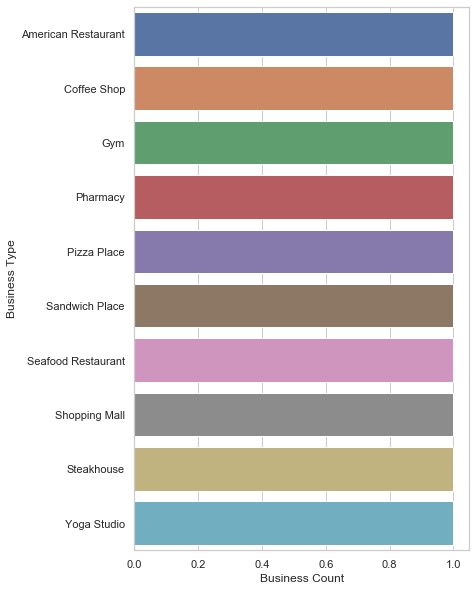

In [59]:
Cluster_5 = pd.DataFrame(manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]])
columnNames = ['Business Type']

Cluster_5_count = pd.DataFrame(columns = columnNames)
Cluster_5_count['Business Type'] = pd.concat([Cluster_5['1st Most Common Venue'], Cluster_5['2nd Most Common Venue'], Cluster_5['3rd Most Common Venue'],
                                             Cluster_5['4th Most Common Venue'], Cluster_5['5th Most Common Venue'], Cluster_5['6th Most Common Venue'], 
                                             Cluster_5['7th Most Common Venue'], Cluster_5['8th Most Common Venue'], Cluster_5['9th Most Common Venue'], 
                                              Cluster_5['10th Most Common Venue']], axis =0, ignore_index =True)

Cluster_5_count['Business Count'] = 1
Cluster_5_count.shape


Cluster_5_count = Cluster_5_count.groupby(['Business Type'])['Business Count'].sum().reset_index()
Cluster_5_count = Cluster_5_count.sort_values(by=['Business Count'], ascending=False)

sns.set(style="whitegrid")
plt.subplots(figsize=(6, 10))
ax = sns.barplot(y = "Business Type", x = "Business Count", data=Cluster_5_count)


In [60]:
fig = ax.get_figure()
fig.savefig("NY_Explore_Cluster_5.png", bbox_inches = 'tight')

In [61]:
NY_Explore_Cluster_5 = set(Cluster_5['Neighborhood'])
print("Neighborhoods in Cluster 5 are: ", NY_Explore_Cluster_5)

Neighborhoods in Cluster 5 are:  {'Marble Hill'}


### Thank you for completing this lab!

This notebook was created by [Alex Aklson](https://www.linkedin.com/in/aklson/) and [Polong Lin](https://www.linkedin.com/in/polonglin/). I hope you found this lab interesting and educational. Feel free to contact us if you have any questions!

This notebook is part of a course on **Coursera** called *Applied Data Science Capstone*. If you accessed this notebook outside the course, you can take this course online by clicking [here](http://cocl.us/DP0701EN_Coursera_Week3_LAB2).

<hr>

Copyright &copy; 2018 [Cognitive Class](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).